# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
# import os
# # Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

C:\Users\putoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.16.1', '4.38.2', '2.1.2+cpu')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


## 1. Loading our MNLI part of the GLUE dataset

In [4]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [6]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

In [7]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

<img src = "figures/BERT_embed.png" width=500>

In [8]:
# !pip3 install requests==2.27.1   

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

In [10]:
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [11]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [12]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [13]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [14]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [15]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [16]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

In [17]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [18]:
# small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(100000))
# small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
# small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))


small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(1000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(100))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(100))

In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [20]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 79]), torch.Size([32, 79]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [21]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [22]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [23]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [24]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [25]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    layer_type
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, layer_type)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            if layer_type == 'top':
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())
            elif layer_type == 'bottom':
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i+6].state_dict())
            elif layer_type == 'odd':
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[(2*i)+1].state_dict())
            elif layer_type == 'even':
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [26]:
for i in range(6):
    print(f"i:{i}, top:{i}, bottom:{i+6}, odd:{(2*i)+1}, even:{2*i}")

i:0, top:0, bottom:6, odd:1, even:0
i:1, top:1, bottom:7, odd:3, even:2
i:2, top:2, bottom:8, odd:5, even:4
i:3, top:3, bottom:9, odd:7, even:6
i:4, top:4, bottom:10, odd:9, even:8
i:5, top:5, bottom:11, odd:11, even:10


In [27]:
#It has 40% less parameters than bert-base-uncased

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [29]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [30]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [31]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

## 7. Learning rate scheduler

In [32]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [33]:
# !pip3 install evaluate

In [34]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

## 9. Train

In [35]:
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def train_model(model):
    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            # predictions, references = accelerator.gather((predictions, batch["labels"]))
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        
        print(f"Epoch at {epoch+1}: Validation loss {eval_loss/len(eval_dataloader):.4f} | Validation Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)


    # Plotting
    epochs_list = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label='Total Train Loss')
    plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
    plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    plt.plot(epochs_list, eval_losses, label='Validation Loss')

    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [36]:
print('Teacher parameters :', count_parameters(teacher_model))
teacher_model = teacher_model.to(device)

Teacher parameters : 109484547


---- Train Top layer model ----
Student parameters   : 66957315
Student parameters % : 61.15686353435797


  0%|          | 0/160 [00:00<?, ?it/s]

 20%|██        | 32/160 [01:38<05:51,  2.75s/it]

Epoch at 1: Train loss 0.3871:
  - Loss_cls: 1.0860
  - Loss_div: 0.0149
  - Loss_cos: 0.0605
Epoch at 1: Validation loss 1.0281 | Validation Acc 0.4800


 40%|████      | 64/160 [03:52<05:03,  3.16s/it]

Epoch at 2: Train loss 0.3508:
  - Loss_cls: 0.9568
  - Loss_div: 0.0401
  - Loss_cos: 0.0556
Epoch at 2: Validation loss 0.9563 | Validation Acc 0.5700


 60%|██████    | 96/160 [06:01<03:22,  3.16s/it]

Epoch at 3: Train loss 0.3134:
  - Loss_cls: 0.8201
  - Loss_div: 0.0640
  - Loss_cos: 0.0561
Epoch at 3: Validation loss 0.9272 | Validation Acc 0.5500


 80%|████████  | 128/160 [08:12<01:39,  3.12s/it]

Epoch at 4: Train loss 0.2898:
  - Loss_cls: 0.6944
  - Loss_div: 0.1089
  - Loss_cos: 0.0662
Epoch at 4: Validation loss 0.9098 | Validation Acc 0.5800


100%|██████████| 160/160 [10:14<00:00,  2.73s/it]

Epoch at 5: Train loss 0.2767:
  - Loss_cls: 0.6344
  - Loss_div: 0.1274
  - Loss_cos: 0.0682
Epoch at 5: Validation loss 0.9077 | Validation Acc 0.5800
Avg Metric 0.5519999999999999


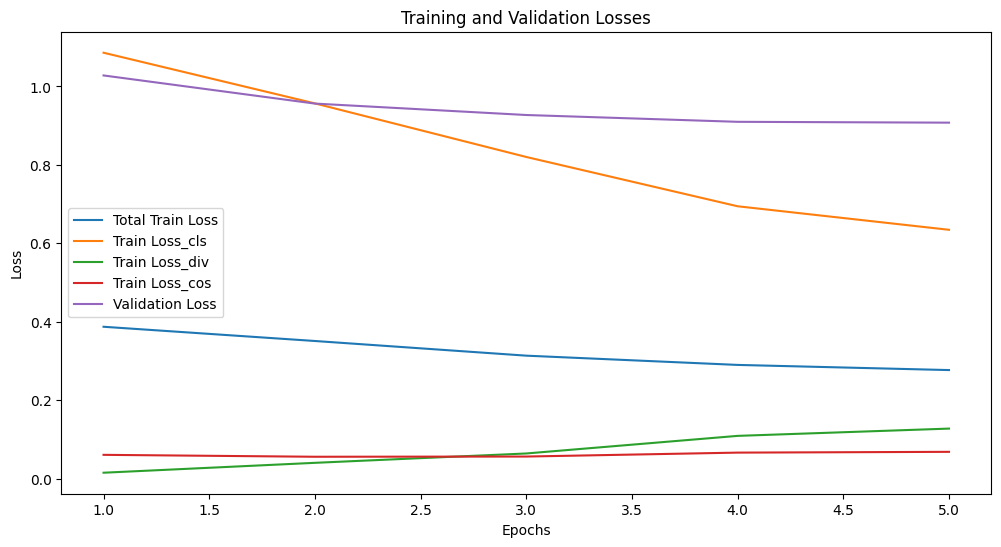

100%|██████████| 160/160 [10:17<00:00,  3.86s/it]


In [37]:
print(f"---- Train Top layer model ----")
top_layer_model = distill_bert_weights(teacher=teacher_model, student=model, layer_type='top')
print('Student parameters   :', count_parameters(top_layer_model))
print('Student parameters % :', (count_parameters(top_layer_model)/count_parameters(teacher_model) * 100))
top_layer_model = top_layer_model.to(device)
train_model(top_layer_model)

---- Train bottom layer model ----
Student parameters   : 66957315
Student parameters % : 61.15686353435797


  0%|          | 0/160 [00:00<?, ?it/s]

 20%|██        | 32/160 [01:40<05:52,  2.76s/it]

Epoch at 1: Train loss 0.4550:
  - Loss_cls: 1.1059
  - Loss_div: 0.0107
  - Loss_cos: 0.2483
Epoch at 1: Validation loss 1.0835 | Validation Acc 0.3600


 40%|████      | 64/160 [03:39<04:34,  2.86s/it]

Epoch at 2: Train loss 0.4561:
  - Loss_cls: 1.1025
  - Loss_div: 0.0110
  - Loss_cos: 0.2547
Epoch at 2: Validation loss 1.0835 | Validation Acc 0.3600


 60%|██████    | 96/160 [05:40<02:55,  2.74s/it]

Epoch at 3: Train loss 0.4526:
  - Loss_cls: 1.0996
  - Loss_div: 0.0111
  - Loss_cos: 0.2472
Epoch at 3: Validation loss 1.0835 | Validation Acc 0.3600


 80%|████████  | 128/160 [10:18<01:57,  3.66s/it]

Epoch at 4: Train loss 0.4523:
  - Loss_cls: 1.1048
  - Loss_div: 0.0111
  - Loss_cos: 0.2410
Epoch at 4: Validation loss 1.0835 | Validation Acc 0.3600


100%|██████████| 160/160 [12:17<00:00,  3.00s/it]

Epoch at 5: Train loss 0.4476:
  - Loss_cls: 1.1017
  - Loss_div: 0.0103
  - Loss_cos: 0.2307
Epoch at 5: Validation loss 1.0835 | Validation Acc 0.3600
Avg Metric 0.36


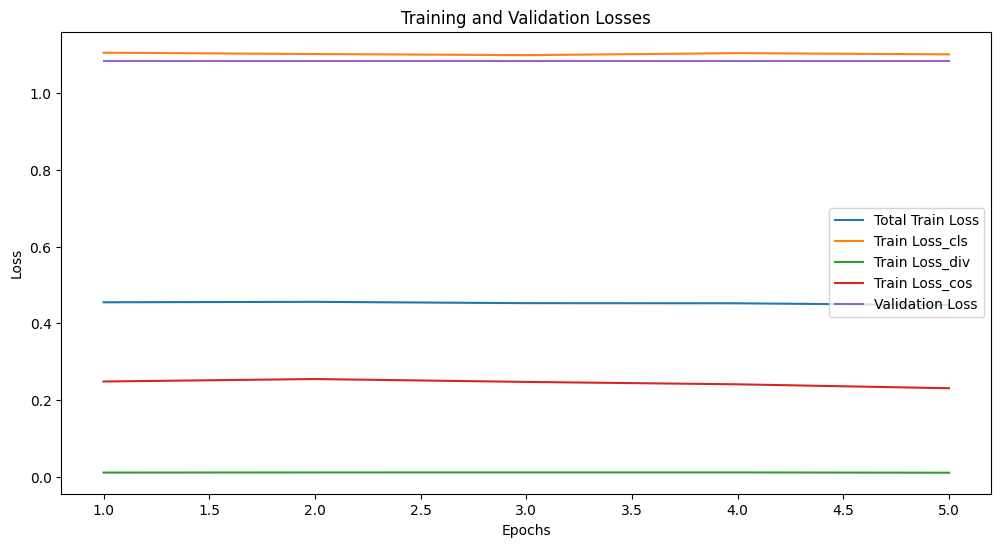

100%|██████████| 160/160 [12:20<00:00,  4.63s/it]


In [38]:
print(f"---- Train bottom layer model ----")
bot_layer_model = distill_bert_weights(teacher=teacher_model, student=model, layer_type='bottom')
print('Student parameters   :', count_parameters(bot_layer_model))
print('Student parameters % :', (count_parameters(bot_layer_model)/count_parameters(teacher_model) * 100))
bot_layer_model = bot_layer_model.to(device)
train_model(bot_layer_model)

---- Train odd layer model ----
Student parameters   : 66957315
Student parameters % : 61.15686353435797


  0%|          | 0/160 [00:00<?, ?it/s]

 20%|██        | 32/160 [01:55<06:02,  2.83s/it]

Epoch at 1: Train loss 0.4106:
  - Loss_cls: 1.1045
  - Loss_div: 0.0084
  - Loss_cos: 0.1188
Epoch at 1: Validation loss 1.0879 | Validation Acc 0.3000


 40%|████      | 64/160 [03:55<05:02,  3.15s/it]

Epoch at 2: Train loss 0.4068:
  - Loss_cls: 1.1035
  - Loss_div: 0.0080
  - Loss_cos: 0.1087
Epoch at 2: Validation loss 1.0879 | Validation Acc 0.3000


 60%|██████    | 96/160 [05:57<03:11,  2.99s/it]

Epoch at 3: Train loss 0.4109:
  - Loss_cls: 1.1031
  - Loss_div: 0.0083
  - Loss_cos: 0.1212
Epoch at 3: Validation loss 1.0879 | Validation Acc 0.3000


 80%|████████  | 128/160 [07:58<01:32,  2.90s/it]

Epoch at 4: Train loss 0.4087:
  - Loss_cls: 1.1013
  - Loss_div: 0.0082
  - Loss_cos: 0.1167
Epoch at 4: Validation loss 1.0879 | Validation Acc 0.3000


100%|██████████| 160/160 [09:59<00:00,  3.53s/it]

Epoch at 5: Train loss 0.4080:
  - Loss_cls: 1.1042
  - Loss_div: 0.0082
  - Loss_cos: 0.1117
Epoch at 5: Validation loss 1.0879 | Validation Acc 0.3000
Avg Metric 0.3


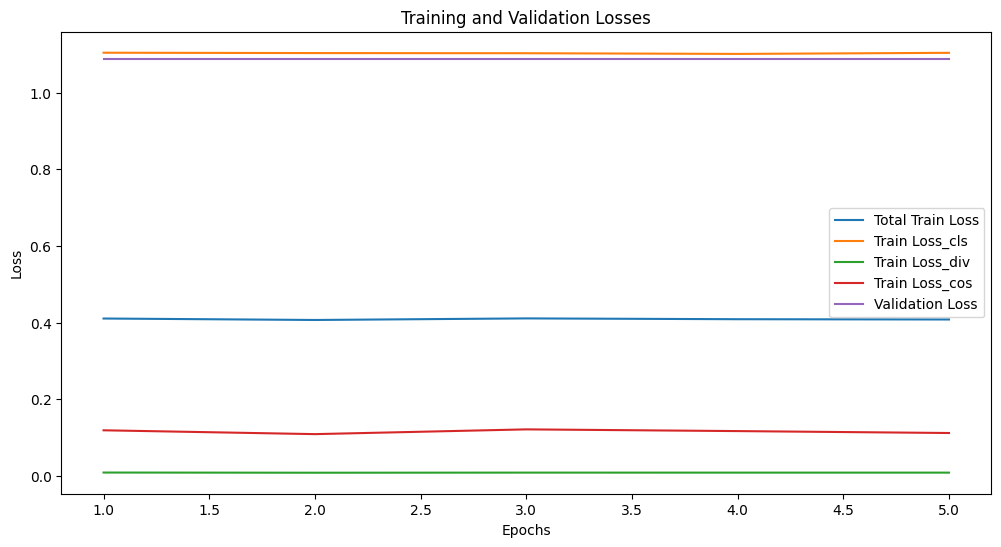

100%|██████████| 160/160 [10:02<00:00,  3.76s/it]


In [39]:
print(f"---- Train odd layer model ----")
odd_layer_model = distill_bert_weights(teacher=teacher_model, student=model, layer_type='odd')
print('Student parameters   :', count_parameters(odd_layer_model))
print('Student parameters % :', (count_parameters(odd_layer_model)/count_parameters(teacher_model) * 100))
odd_layer_model = odd_layer_model.to(device)
train_model(odd_layer_model)

---- Train even layer model ----
Student parameters   : 66957315
Student parameters % : 61.15686353435797


  0%|          | 0/160 [00:00<?, ?it/s]

 20%|██        | 32/160 [01:43<05:24,  2.53s/it]

Epoch at 1: Train loss 0.7306:
  - Loss_cls: 1.1320
  - Loss_div: 0.0458
  - Loss_cos: 1.0141
Epoch at 1: Validation loss 1.1147 | Validation Acc 0.3400


 40%|████      | 64/160 [03:46<04:38,  2.90s/it]

Epoch at 2: Train loss 0.7272:
  - Loss_cls: 1.1288
  - Loss_div: 0.0447
  - Loss_cos: 1.0080
Epoch at 2: Validation loss 1.1147 | Validation Acc 0.3400


 60%|██████    | 96/160 [06:28<08:15,  7.74s/it]

Epoch at 3: Train loss 0.7295:
  - Loss_cls: 1.1352
  - Loss_div: 0.0454
  - Loss_cos: 1.0079
Epoch at 3: Validation loss 1.1147 | Validation Acc 0.3400


 80%|████████  | 128/160 [09:03<01:22,  2.58s/it]

Epoch at 4: Train loss 0.7203:
  - Loss_cls: 1.1310
  - Loss_div: 0.0444
  - Loss_cos: 0.9855
Epoch at 4: Validation loss 1.1147 | Validation Acc 0.3400


100%|██████████| 160/160 [10:57<00:00,  2.54s/it]

Epoch at 5: Train loss 0.7188:
  - Loss_cls: 1.1338
  - Loss_div: 0.0450
  - Loss_cos: 0.9777
Epoch at 5: Validation loss 1.1147 | Validation Acc 0.3400
Avg Metric 0.34


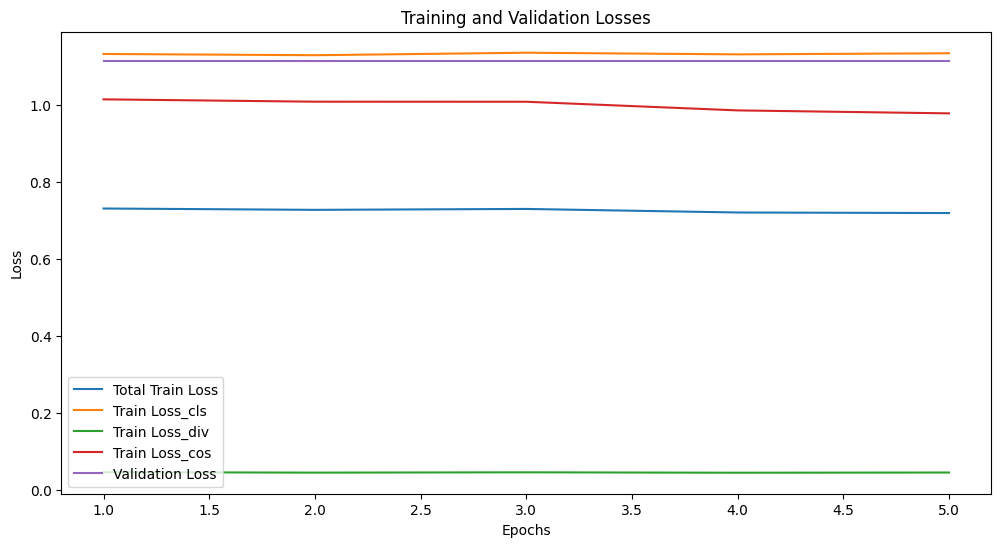

100%|██████████| 160/160 [11:00<00:00,  4.13s/it]


In [40]:
print(f"---- Train even layer model ----")
eve_layer_model = distill_bert_weights(teacher=teacher_model, student=model, layer_type='even')
print('Student parameters   :', count_parameters(eve_layer_model))
print('Student parameters % :', (count_parameters(eve_layer_model)/count_parameters(teacher_model) * 100))
eve_layer_model = eve_layer_model.to(device)
train_model(eve_layer_model)

### Appendix (Teacher Model)

In [41]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

train_losses = []
eval_losses = []

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    train_losses.append(train_loss / len(train_dataloader))
    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    eval_loss = 0
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)

        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses.append(eval_loss / len(eval_dataloader))

    print(f"Epoch at {epoch+1}: Validation loss {eval_loss/len(eval_dataloader):.4f} | Validation Acc {eval_metric['accuracy']:.4f}")
    # print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

 20%|██        | 32/160 [02:14<07:05,  3.32s/it]

Epoch at 1: Train loss 1.0835:
Epoch at 1: Validation loss 1.0227 | Validation Acc 0.5200


 40%|████      | 64/160 [04:44<05:16,  3.30s/it]

Epoch at 2: Train loss 0.8114:
Epoch at 2: Validation loss 1.0771 | Validation Acc 0.5600


 60%|██████    | 96/160 [07:14<03:49,  3.58s/it]

Epoch at 3: Train loss 0.4970:
Epoch at 3: Validation loss 1.1402 | Validation Acc 0.6600


 80%|████████  | 128/160 [09:46<01:51,  3.48s/it]

Epoch at 4: Train loss 0.1931:
Epoch at 4: Validation loss 1.2569 | Validation Acc 0.6800


100%|██████████| 160/160 [12:18<00:00,  3.59s/it]

Epoch at 5: Train loss 0.0856:
Epoch at 5: Validation loss 1.4365 | Validation Acc 0.6700
Avg Metric 0.6180000000000001
